<a href="https://colab.research.google.com/github/shobhanb/ml-nlp-practice/blob/master/NLP_IMDB_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing ML practice
**Sentiment classification - IMDB Reviews dataset**

Version 2.0
* TFDS for data retrieval
* NLTK for stop words / basic stuff
* TF HUB for imported embedding layer
* Keras for RNN model

# Conclusion

* GNEWS 20dim - performance to 86% 
* Wiki Words 250 - Performance decreased!


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import os, random, datetime

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.data.experimental import AUTOTUNE
tfds.disable_progress_bar()

import nltk, string, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
# Since Test is same size as Train (25k) - let's split Test into Validation & Test 50/50

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'imdb_reviews/plain_text', 
    split=['train', 'test[:50%]', 'test[50%:]'], 
    as_supervised=True, 
    with_info=True, 
    shuffle_files=True
)



Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQDHUPG/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQDHUPG/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQDHUPG/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [196]:
for a, b in ds_train.take(4):
    print(a)
    print(b)
    


tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [4]:
BATCH_SIZE = 128

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(AUTOTUNE)

ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(AUTOTUNE)


In [5]:
hub_link = 'https://tfhub.dev/google/Wiki-words-250/2'
lr = 0.001 
embedding_dim = 250

embed_layer = hub.KerasLayer(
    hub_link, 
    trainable=True,
    output_shape=[embedding_dim], 
    input_shape=[], 
    dtype=tf.string
)

model = tf.keras.Sequential([
    embed_layer,
    layers.Reshape((embedding_dim, 1)),
    layers.Bidirectional(layers.LSTM(embedding_dim)),
    layers.Dropout(0.5),
    layers.Dense(embedding_dim, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 250)               252343750 
_________________________________________________________________
reshape (Reshape)            (None, 250, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 500)               504000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               125250    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 252,973,251
Trainable params: 252,973,251
Non-trainable params: 0
__________________________________________

In [6]:
EPOCHS=10

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val
)


Epoch 1/10
196/196 [==============================] - 82s 419ms/step - loss: 0.5781 - accuracy: 0.7348 - val_loss: 0.3418 - val_accuracy: 0.8539
Epoch 2/10
196/196 [==============================] - 80s 410ms/step - loss: 0.2223 - accuracy: 0.9141 - val_loss: 0.3286 - val_accuracy: 0.8629
Epoch 3/10
196/196 [==============================] - 80s 410ms/step - loss: 0.1041 - accuracy: 0.9646 - val_loss: 0.4403 - val_accuracy: 0.8470
Epoch 4/10
196/196 [==============================] - 80s 410ms/step - loss: 0.0535 - accuracy: 0.9830 - val_loss: 0.4699 - val_accuracy: 0.8472
Epoch 5/10
196/196 [==============================] - 80s 410ms/step - loss: 0.0354 - accuracy: 0.9892 - val_loss: 0.6864 - val_accuracy: 0.8319
Epoch 6/10
196/196 [==============================] - 81s 411ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.9551 - val_accuracy: 0.8303
Epoch 7/10
196/196 [==============================] - 80s 410ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 1.3713 - val_ac

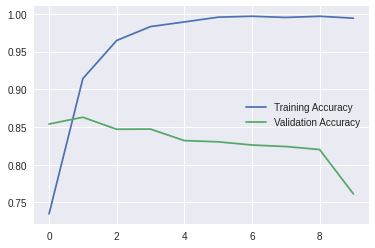

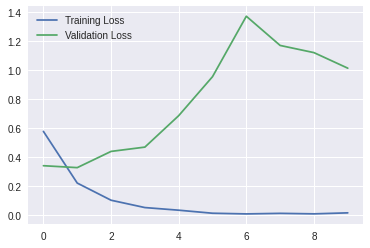

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()

plt.show()


In [229]:
model.evaluate(ds_test)

98/98 [==============================] - 1s 12ms/step - loss: 0.4092 - accuracy: 0.8602


[0.40917858481407166, 0.8601599931716919]